In [1]:
import os
import math
import numpy as np
import json
from tensorflow import keras
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization

DATASET_DIR = 'drive/My Drive/Datasets/SETI_Radio_Signals'
TRAIN_DIR = os.path.join(DATASET_DIR, 'train')
VAL_DIR = os.path.join(DATASET_DIR, 'valid')
TEST_DIR = os.path.join(DATASET_DIR, 'test')

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
from keras.preprocessing.image import img_to_array, load_img
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# Reading all the PNG files in the training folder
signal_files = glob.glob(TRAIN_DIR+'/*/*.png')

# Reading first file of all 7 classes for visualization
visualization_files = [signal_files[i] for i in range(0, 5600, 800)]


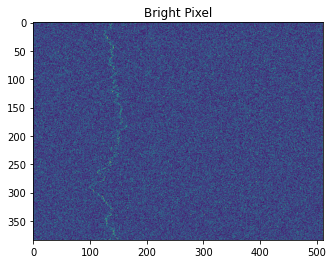

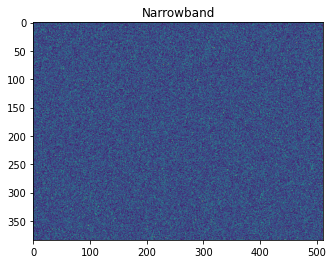

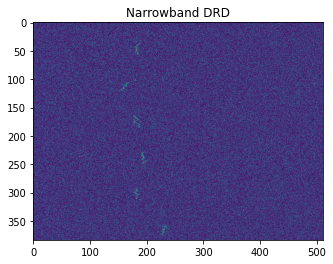

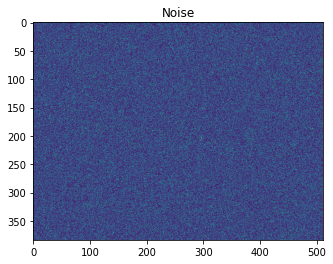

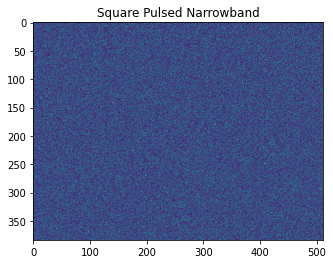

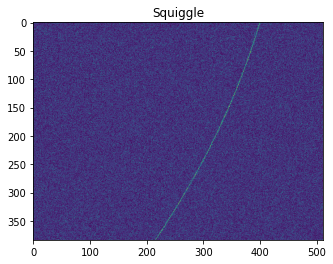

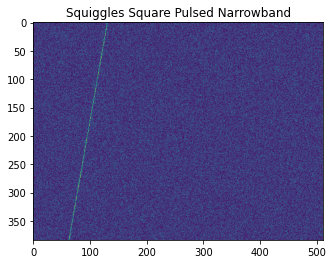

In [6]:
class_names = ["Bright Pixel", "Narrowband", "Narrowband DRD", "Noise", "Square Pulsed Narrowband", "Squiggle", "Squiggles Square Pulsed Narrowband"]
# Visualization of image of each class
for i in range(0, 7):
  signal_file = visualization_files[i]
  signal_img = load_img(signal_file)
  signal_img_arr = img_to_array(signal_img)
  plt.figure()
  plt.imshow(signal_img_arr/255.)
  plt.title(class_names[i], fontsize=12)
plt.show()

In [0]:
# Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255.,
                                  zoom_range=0.05,
                                  rotation_range=180,
                                  vertical_flip=True,
                                  horizontal_flip=True, 
                                  fill_mode='reflect')

valid_datagen = ImageDataGenerator(rescale=1./255.)
test_datagen = ImageDataGenerator(rescale=1./255.)

callback_list = [
    keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [8]:
training_set = train_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                classes=['brightpixel', 'narrowband', 
                                                          'narrowbanddrd', 'noise', 
                                                          'squarepulsednarrowband', 'squiggle',
                                                          'squigglesquarepulsednarrowband'],
                                                target_size=(192, 192),
                                                batch_size=64,
                                                class_mode='categorical',
                                                interpolation='bicubic',
                                                shuffle=True, seed=42)

Found 5600 images belonging to 7 classes.


In [9]:
validation_set = valid_datagen.flow_from_directory(directory=VAL_DIR,
                                                  classes=['brightpixel', 'narrowband', 
                                                          'narrowbanddrd', 'noise', 
                                                          'squarepulsednarrowband', 'squiggle',
                                                          'squigglesquarepulsednarrowband'],
                                                  target_size=(192, 192),
                                                  batch_size=64,
                                                  class_mode='categorical',
                                                  interpolation='bicubic',
                                                  shuffle=False, seed=42)

Found 700 images belonging to 7 classes.


In [0]:
# Train ResNet
def train_resnet():
  INPUT_SHAPE = (192, 192, 3)
  # load pre-trained resnet model
  resnet = keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', 
                                                input_shape=INPUT_SHAPE)

  # set all layers to be trainable 
  resnet.trainable = True
  for layer in resnet.layers:
      resnet.trainable = True

  # add dense and output layers    
  base_resnet = resnet
  base_out = base_resnet.output
  pool_out = keras.layers.Flatten()(base_out)
  hidden1 = keras.layers.Dense(1024, activation='relu')(pool_out)
  drop1 = keras.layers.Dropout(rate=0.2)(hidden1)
  hidden2 = keras.layers.Dense(512, activation='relu')(drop1)
  drop2 = keras.layers.Dropout(rate=0.2)(hidden2)

  out = keras.layers.Dense(7, activation='softmax')(drop2)

  model = keras.Model(inputs=base_resnet.input, outputs=out)
  model.compile(optimizer=keras.optimizers.RMSprop(lr=1e-6),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
  return model

In [0]:
def cnn_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), input_shape=(192, 192, 3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (5, 5)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(32, (3, 3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(7, activation='softmax'))

  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  
  return model

In [12]:
model = train_resnet()
#model = cnn_model()
history = model.fit_generator(
  training_set,
  steps_per_epoch=5600 // 64,
  epochs=20,
  validation_data=validation_set,
  validation_steps=700 // 64,
  callbacks=callback_list, verbose=1,
)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Epoch 1/20
87/87 [==============================] - 151s 2s/step - loss: 2.3373 - accuracy: 0.2287 - val_loss: 14.3084 - val_accuracy: 0.1562
Epoch 2/20
87/87 [==============================] - 139s 2s/step - loss: 1.9566 - accuracy: 0.3316 - val_loss: 15.7357 - val_accuracy: 0.1572
Epoch 3/20
87/87 [==============================] - 134s 2s/step - loss: 1.7707 - accuracy: 0.3882 - val_loss: 70.5841 - val_accuracy: 0.1572
Epoch 4/20
87/87 [==============================] - 133s 2s/step - loss: 1.6090 - accuracy: 0.4386 - val_loss: 114.3581 - val_accuracy: 0.1572
Epoch 5/20
87/87 [==============================] - 127s 1s/step - loss: 1.5169 - accuracy: 0.4545 - val_loss: 131.1111 - val_accuracy: 0.1572
Epoch 6/20
87/87 [==============================] - 126s 1s/step - loss: 1.4189 - accuracy: 0.4886 - val_loss: 46.1701 - val_accuracy: 0.1572
Epoch 7/20
87/87 [==============================] - 124s 1s/step - loss: 1.3759 - accuracy: 0.5069 - val_loss: 3.4505 - val_accuracy: 0.0881
Epoch

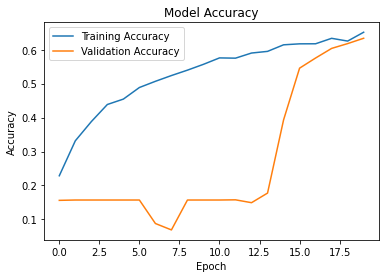

In [13]:
# Accuracy Graph
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

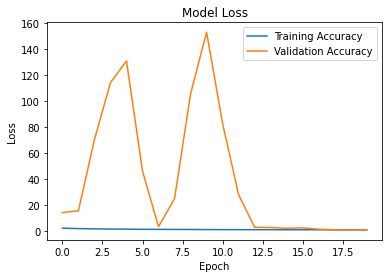

In [14]:
# Loss Graph
plt.plot(history.history['loss'], label='Training Accuracy')
plt.plot(history.history['val_loss'], label='Validation Accuracy')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [15]:
# Testing
test_set = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                  classes=['brightpixel', 'narrowband', 
                                                           'narrowbanddrd', 'noise', 
                                                           'squarepulsednarrowband', 'squiggle',
                                                           'squigglesquarepulsednarrowband'],
                                                  target_size=(192, 192),
                                                  batch_size=1,
                                                  class_mode='categorical',
                                                  interpolation='bicubic',
                                                  shuffle=False, seed=42)

Found 700 images belonging to 7 classes.


In [16]:
test_set.class_indices

{'brightpixel': 0,
 'narrowband': 1,
 'narrowbanddrd': 2,
 'noise': 3,
 'squarepulsednarrowband': 4,
 'squiggle': 5,
 'squigglesquarepulsednarrowband': 6}

In [17]:
test_set.filenames

['brightpixel/1004_brightpixel.png',
 'brightpixel/1056_brightpixel.png',
 'brightpixel/1112_brightpixel.png',
 'brightpixel/1128_brightpixel.png',
 'brightpixel/1219_brightpixel.png',
 'brightpixel/1293_brightpixel.png',
 'brightpixel/1300_brightpixel.png',
 'brightpixel/1301_brightpixel.png',
 'brightpixel/1399_brightpixel.png',
 'brightpixel/1401_brightpixel.png',
 'brightpixel/1411_brightpixel.png',
 'brightpixel/1469_brightpixel.png',
 'brightpixel/1499_brightpixel.png',
 'brightpixel/1535_brightpixel.png',
 'brightpixel/1650_brightpixel.png',
 'brightpixel/1651_brightpixel.png',
 'brightpixel/174_brightpixel.png',
 'brightpixel/1931_brightpixel.png',
 'brightpixel/1944_brightpixel.png',
 'brightpixel/1949_brightpixel.png',
 'brightpixel/1979_brightpixel.png',
 'brightpixel/2132_brightpixel.png',
 'brightpixel/2136_brightpixel.png',
 'brightpixel/2211_brightpixel.png',
 'brightpixel/2236_brightpixel.png',
 'brightpixel/2558_brightpixel.png',
 'brightpixel/2597_brightpixel.png',
 '

In [18]:
class_label_mapping = {v:k for k,v in test_set.class_indices.items()}
class_label_mapping

{0: 'brightpixel',
 1: 'narrowband',
 2: 'narrowbanddrd',
 3: 'noise',
 4: 'squarepulsednarrowband',
 5: 'squiggle',
 6: 'squigglesquarepulsednarrowband'}

In [19]:
test_data = [next(test_set) for i in range(700)]
test_data

[(array([[[[0.27450982, 0.14509805, 0.454902  ],
           [0.26666668, 0.19215688, 0.48627454],
           [0.27450982, 0.13725491, 0.44705886],
           ...,
           [0.27450982, 0.1254902 , 0.43921572],
           [0.27450982, 0.14117648, 0.45098042],
           [0.27058825, 0.15686275, 0.45882356]],
  
          [[0.27058825, 0.1254902 , 0.43529415],
           [0.27058825, 0.18039216, 0.4784314 ],
           [0.26666668, 0.16470589, 0.45882356],
           ...,
           [0.27450982, 0.14509805, 0.454902  ],
           [0.27450982, 0.17254902, 0.4784314 ],
           [0.27450982, 0.14901961, 0.454902  ]],
  
          [[0.27450982, 0.14901961, 0.45882356],
           [0.2784314 , 0.12941177, 0.4431373 ],
           [0.27058825, 0.12941177, 0.43529415],
           ...,
           [0.27058825, 0.16078432, 0.46274513],
           [0.2784314 , 0.1254902 , 0.4431373 ],
           [0.27058825, 0.13725491, 0.4431373 ]],
  
          ...,
  
          [[0.27450982, 0.12941177, 0.44

In [20]:
test_data_X = [data[0] for data in test_data]
test_data_X

[array([[[[0.27450982, 0.14509805, 0.454902  ],
          [0.26666668, 0.19215688, 0.48627454],
          [0.27450982, 0.13725491, 0.44705886],
          ...,
          [0.27450982, 0.1254902 , 0.43921572],
          [0.27450982, 0.14117648, 0.45098042],
          [0.27058825, 0.15686275, 0.45882356]],
 
         [[0.27058825, 0.1254902 , 0.43529415],
          [0.27058825, 0.18039216, 0.4784314 ],
          [0.26666668, 0.16470589, 0.45882356],
          ...,
          [0.27450982, 0.14509805, 0.454902  ],
          [0.27450982, 0.17254902, 0.4784314 ],
          [0.27450982, 0.14901961, 0.454902  ]],
 
         [[0.27450982, 0.14901961, 0.45882356],
          [0.2784314 , 0.12941177, 0.4431373 ],
          [0.27058825, 0.12941177, 0.43529415],
          ...,
          [0.27058825, 0.16078432, 0.46274513],
          [0.2784314 , 0.1254902 , 0.4431373 ],
          [0.27058825, 0.13725491, 0.4431373 ]],
 
         ...,
 
         [[0.27450982, 0.12941177, 0.4431373 ],
          [0.27450

In [21]:
test_data_X = np.array(np.squeeze(test_data_X, axis=1))
test_data_X

array([[[[0.27450982, 0.14509805, 0.454902  ],
         [0.26666668, 0.19215688, 0.48627454],
         [0.27450982, 0.13725491, 0.44705886],
         ...,
         [0.27450982, 0.1254902 , 0.43921572],
         [0.27450982, 0.14117648, 0.45098042],
         [0.27058825, 0.15686275, 0.45882356]],

        [[0.27058825, 0.1254902 , 0.43529415],
         [0.27058825, 0.18039216, 0.4784314 ],
         [0.26666668, 0.16470589, 0.45882356],
         ...,
         [0.27450982, 0.14509805, 0.454902  ],
         [0.27450982, 0.17254902, 0.4784314 ],
         [0.27450982, 0.14901961, 0.454902  ]],

        [[0.27450982, 0.14901961, 0.45882356],
         [0.2784314 , 0.12941177, 0.4431373 ],
         [0.27058825, 0.12941177, 0.43529415],
         ...,
         [0.27058825, 0.16078432, 0.46274513],
         [0.2784314 , 0.1254902 , 0.4431373 ],
         [0.27058825, 0.13725491, 0.4431373 ]],

        ...,

        [[0.27450982, 0.12941177, 0.4431373 ],
         [0.27450982, 0.13725491, 0.44705886]

In [22]:
test_data_y = np.array([fname.split('/')[0] for fname in test_set.filenames])
test_data_y

array(['brightpixel', 'brightpixel', 'brightpixel', 'brightpixel',
       'brightpixel', 'brightpixel', 'brightpixel', 'brightpixel',
       'brightpixel', 'brightpixel', 'brightpixel', 'brightpixel',
       'brightpixel', 'brightpixel', 'brightpixel', 'brightpixel',
       'brightpixel', 'brightpixel', 'brightpixel', 'brightpixel',
       'brightpixel', 'brightpixel', 'brightpixel', 'brightpixel',
       'brightpixel', 'brightpixel', 'brightpixel', 'brightpixel',
       'brightpixel', 'brightpixel', 'brightpixel', 'brightpixel',
       'brightpixel', 'brightpixel', 'brightpixel', 'brightpixel',
       'brightpixel', 'brightpixel', 'brightpixel', 'brightpixel',
       'brightpixel', 'brightpixel', 'brightpixel', 'brightpixel',
       'brightpixel', 'brightpixel', 'brightpixel', 'brightpixel',
       'brightpixel', 'brightpixel', 'brightpixel', 'brightpixel',
       'brightpixel', 'brightpixel', 'brightpixel', 'brightpixel',
       'brightpixel', 'brightpixel', 'brightpixel', 'brightpix

In [23]:
class_labels = list(set(test_data_y))
class_labels

['squiggle',
 'noise',
 'narrowbanddrd',
 'squigglesquarepulsednarrowband',
 'brightpixel',
 'squarepulsednarrowband',
 'narrowband']

In [24]:
test_data_X.shape, test_data_y.shape

((700, 192, 192, 3), (700,))

In [25]:
predictions = model.predict(test_data_X, verbose=1)
predictions

700/700 [==============================] - 4s 5ms/step


array([[2.13761285e-01, 6.01832867e-02, 2.03229431e-02, ...,
        2.10462078e-01, 1.32673860e-01, 3.52252722e-01],
       [8.41917157e-01, 1.55894477e-02, 1.05379233e-02, ...,
        4.85308878e-02, 3.29953246e-02, 4.66550663e-02],
       [2.67572820e-01, 2.03642752e-02, 1.33895865e-02, ...,
        3.84182304e-01, 4.26854417e-02, 2.67390013e-01],
       ...,
       [5.91284604e-08, 4.57430751e-08, 3.35248025e-08, ...,
        9.94206309e-01, 9.24966486e-08, 5.79347694e-03],
       [4.37367940e-03, 6.76266924e-02, 1.25433698e-01, ...,
        9.11958069e-02, 6.23543322e-01, 7.99736977e-02],
       [3.24198976e-02, 4.58328426e-03, 3.79147171e-03, ...,
        3.87258261e-01, 1.11783575e-02, 5.60104430e-01]], dtype=float32)

In [26]:
prediction_labels = [class_label_mapping[i] for i in predictions.argmax(axis=1)]
prediction_labels

['squigglesquarepulsednarrowband',
 'brightpixel',
 'squarepulsednarrowband',
 'brightpixel',
 'noise',
 'noise',
 'brightpixel',
 'noise',
 'brightpixel',
 'brightpixel',
 'brightpixel',
 'noise',
 'squiggle',
 'brightpixel',
 'squarepulsednarrowband',
 'brightpixel',
 'brightpixel',
 'brightpixel',
 'noise',
 'noise',
 'brightpixel',
 'brightpixel',
 'squarepulsednarrowband',
 'brightpixel',
 'squiggle',
 'noise',
 'noise',
 'brightpixel',
 'brightpixel',
 'brightpixel',
 'brightpixel',
 'brightpixel',
 'brightpixel',
 'squigglesquarepulsednarrowband',
 'brightpixel',
 'noise',
 'noise',
 'squigglesquarepulsednarrowband',
 'brightpixel',
 'brightpixel',
 'noise',
 'squiggle',
 'noise',
 'brightpixel',
 'brightpixel',
 'brightpixel',
 'brightpixel',
 'noise',
 'brightpixel',
 'squigglesquarepulsednarrowband',
 'squigglesquarepulsednarrowband',
 'brightpixel',
 'squigglesquarepulsednarrowband',
 'noise',
 'brightpixel',
 'squigglesquarepulsednarrowband',
 'brightpixel',
 'squigglesquar

In [27]:
print(classification_report(y_true=test_data_y, y_pred=prediction_labels))

                                precision    recall  f1-score   support

                   brightpixel       0.95      0.53      0.68       100
                    narrowband       0.64      0.64      0.64       100
                 narrowbanddrd       0.68      0.44      0.53       100
                         noise       0.55      0.80      0.65       100
        squarepulsednarrowband       0.62      0.54      0.58       100
                      squiggle       0.66      0.82      0.73       100
squigglesquarepulsednarrowband       0.55      0.66      0.60       100

                      accuracy                           0.63       700
                     macro avg       0.66      0.63      0.63       700
                  weighted avg       0.66      0.63      0.63       700



In [29]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_true=test_data_y, y_pred=prediction_labels))

0.6328571428571429
